<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC2_2020_NB_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clustering con scikit-learn#


Scopo: familiarizzare con l'implementazione di algoritmi di clustering usando il package scikit-learn.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Parte 1: confronto e visualizzazione di differenti algoritmi di clsutering disponibili in scikit-learn ###

* esempio da scikit-learn: [link](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)

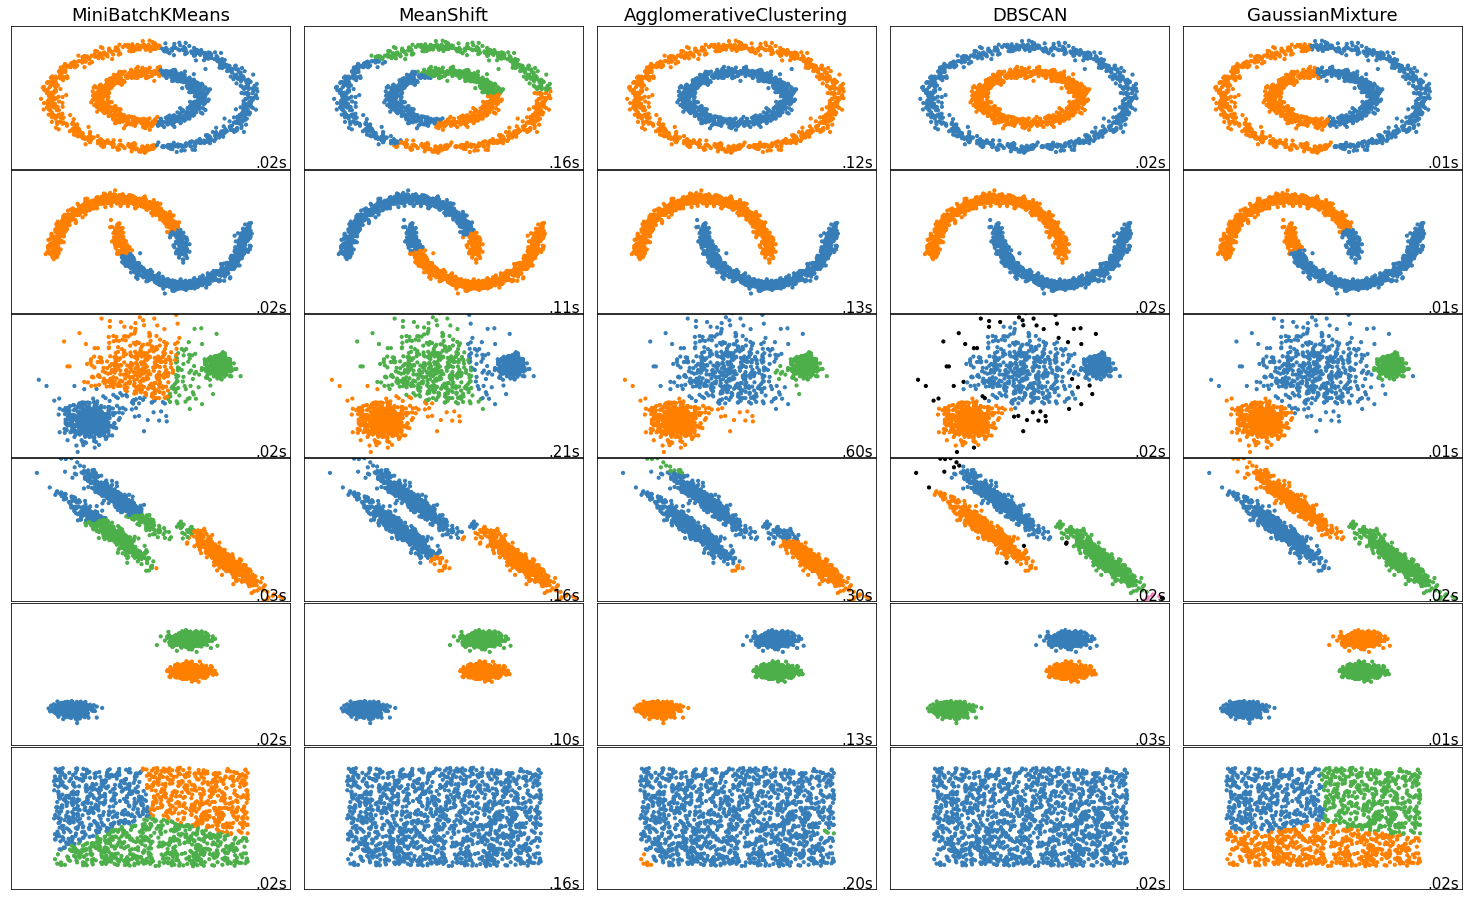

In [0]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate different toy datasets. We choose the size big enough to see the 
# scalability of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]


# loop su i 6 datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

# Algoritmi di clustering per il confronto
    clustering_algorithms = (
        # k-means (con mini-batch)
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        #('SpectralClustering', spectral),
        #('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        #('OPTICS', optics),
        #('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### Analisi risultati: ###

* DBSCAN tipicamente funziona meglio degli altri algoritmi dal punto di vista dell'accuracy nelle predizioni ma fallisce nel terzo dataset

> NOTA: gli algoritmi basati sulla densità dei punti, quindi basati su informazioni locali, funzionano bene con dataset in cui i punti di una stessa classe sono connessi tra loto (dataset topologici), come quelli della righe 1,2, mentre possono avere problemi con dataset con grandi fluttuazioni nelle distribuzioni di densità del dataset *terza riga), e scalano male con alta dimensionalità delle feature

* gli algoritmi basati su metriche di distanza (tipo k-means) invece funzionano male su i primi due dataset e ovviamente quando il numero di cluster impostato è lontano dal valore vero (ultima distribuzione).


### Parte 2: Applicazione ad un dataset reale e analisi dei risultati con l'algoritmo k-means ###

Dataset: World Happiness Report 2016

The World Happiness Report is a landmark survey of the state of global happiness.

The happiness scores and rankings use data from the Gallup World Poll. The scores are based on answers to the main life evaluation question asked in the poll.

The columns following the happiness score estimate the extent to which each of six factors – economic production, social support, life expectancy, freedom, absence of corruption, and generosity – contribute to making life evaluations higher in each country than they are in Dystopia, a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors. They have no impact on the total score reported for each country, but they do explain why some countries rank higher than others.

In [0]:
#leggiamo il dataset con pandas

import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/2016.csv')
data

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Benin,Sub-Saharan Africa,153,3.484,3.404,3.564,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812
153,Afghanistan,Southern Asia,154,3.360,3.288,3.432,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558
154,Togo,Sub-Saharan Africa,155,3.303,3.192,3.414,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540
155,Syria,Middle East and Northern Africa,156,3.069,2.936,3.202,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789


In [0]:
# controllo sul contenuto

#lista delle feature (per la selezione nel dataframe pandas)

sel_features = ['Economy (GDP per Capita)','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual']

In [0]:
# summary statistic del dataset

data[sel_features].describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.953880,0.793621,0.557619,0.370994,0.137624,0.242635,2.325807
std,0.412595,0.266706,0.229349,0.145507,0.111038,0.133756,0.542220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817890
25%,0.670240,0.641840,0.382910,0.257480,0.061260,0.154570,2.031710
50%,1.027800,0.841420,0.596590,0.397470,0.105470,0.222450,2.290740
75%,1.279640,1.021520,0.729930,0.484530,0.175540,0.311850,2.664650
max,1.824270,1.183260,0.952770,0.608480,0.505210,0.819710,3.837720


In [0]:
# controllo sulla correlazione dei dati

data[sel_features].corr()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Economy (GDP per Capita),1.000000,0.669540,0.837067,0.362283,0.294185,-0.025531,0.068624
Family,0.669540,1.000000,0.588377,0.450208,0.213561,0.089629,0.119672
Health (Life Expectancy),0.837067,0.588377,1.000000,0.341199,0.249583,0.075987,0.100857
Freedom,0.362283,0.450208,0.341199,1.000000,0.502054,0.361751,0.091631
Trust (Government Corruption),0.294185,0.213561,0.249583,0.502054,1.000000,0.305930,-0.002909
Generosity,-0.025531,0.089629,0.075987,0.361751,0.305930,1.000000,-0.133001
Dystopia Residual,0.068624,0.119672,0.100857,0.091631,-0.002909,-0.133001,1.000000


alcune feature mostrano una certa correlazione ...

In [0]:
# visualizzazione con t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# sklearn tSNE con pre-pca applicata 
# typical value for perplexity between 5 and 50 (should be tested)
tsne = TSNE(n_components=2, init='pca', perplexity = 10)
tsne_data = tsne.fit_transform(data[sel_features])

In [0]:
# salviamo i risultati nel dataframe

data['tsne-one'] = tsne_data[:,0]
data['tsne-two'] = tsne_data[:,1]

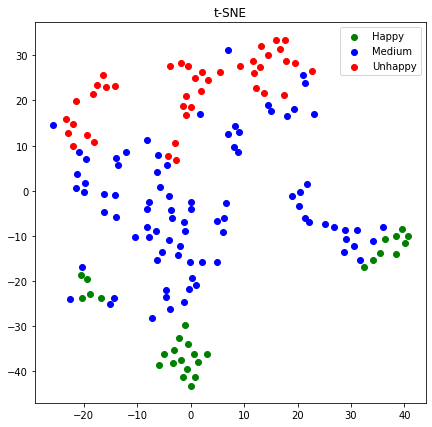

In [0]:
#plot dei risultati
plt.figure(figsize=(7,7))

happy = data.loc[data['Happiness Score']>=6.5]
medium = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<6.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['tsne-one'], happy['tsne-two'], c='green', label='Happy')
plt.scatter(medium['tsne-one'], medium['tsne-two'], c='blue', label='Medium')
plt.scatter(unhappy['tsne-one'], unhappy['tsne-two'], c='red', label='Unhappy')
plt.legend()
plt.title('t-SNE');

si notano due gruppi distinti di paesi felici ... andiamo a controllare

In [0]:
happy.loc[data['tsne-one']>10]

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,tsne-one,tsne-two
10,Israel,Middle East and Northern Africa,11,7.267,7.199,7.335,1.33766,0.99537,0.84917,0.36432,0.08728,0.32288,3.31029,38.378937,-14.061131
13,Costa Rica,Latin America and Caribbean,14,7.087,6.999,7.175,1.06879,1.02152,0.76146,0.55225,0.10547,0.22553,3.35168,35.477821,-13.763563
14,Puerto Rico,Latin America and Caribbean,15,7.039,6.794,7.284,1.35943,1.08113,0.77758,0.46823,0.12275,0.22202,3.00760,40.067146,-11.575621
16,Brazil,Latin America and Caribbean,17,6.952,6.875,7.029,1.08754,1.03938,0.61415,0.40425,0.14166,0.15776,3.50733,34.105885,-15.301084
20,Mexico,Latin America and Caribbean,21,6.778,6.680,6.876,1.11508,0.71460,0.71143,0.37709,0.18355,0.11735,3.55906,32.480446,-16.993153
23,Chile,Latin America and Caribbean,24,6.705,6.615,6.795,1.21670,0.90587,0.81883,0.37789,0.11451,0.31595,2.95505,39.464314,-8.413197
24,Panama,Latin America and Caribbean,25,6.701,6.601,6.801,1.18306,0.98912,0.70835,0.48927,0.08423,0.24180,3.00559,38.414921,-10.049417
25,Argentina,Latin America and Caribbean,26,6.650,6.560,6.740,1.15137,1.06612,0.69711,0.42284,0.07296,0.10989,3.12985,36.271248,-10.698177
26,Czech Republic,Central and Eastern Europe,27,6.596,6.515,6.677,1.30915,1.00793,0.76376,0.41418,0.03986,0.09929,2.96211,40.672615,-10.071486


In [0]:
happy.loc[data['tsne-one']<10]

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,tsne-one,tsne-two
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,0.818631,-41.273136
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,-1.366023,-41.301208
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,-5.991512,-38.532486
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,-0.687390,-39.445026
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,0.011341,-43.163250
5,Canada,North America,6,7.404,7.335,7.473,1.44015,1.09610,0.82760,0.57370,0.31329,0.44834,2.70485,-1.786754,-37.532829
6,Netherlands,Western Europe,7,7.339,7.284,7.394,1.46468,1.02912,0.81231,0.55211,0.29927,0.47416,2.70749,-3.260576,-38.198681
7,New Zealand,Australia and New Zealand,8,7.334,7.264,7.404,1.36066,1.17278,0.83096,0.58147,0.41904,0.49401,2.47553,2.980772,-36.246441
8,Australia,Australia and New Zealand,9,7.313,7.241,7.385,1.44443,1.10476,0.85120,0.56837,0.32331,0.47407,2.54650,0.660523,-36.281292
9,Sweden,Western Europe,10,7.291,7.227,7.355,1.45181,1.08764,0.83121,0.58218,0.40867,0.38254,2.54734,1.458367,-37.954338


In [0]:
# Visualizzazione con PCA

from sklearn.decomposition import PCA

#consideriamo solo le prime tre componenti
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data[sel_features].values)

data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1] 

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#NOTA: l'explained variation indica quanto ciascuna componente contribusice alla varianza totale del campione

Explained variation per principal component: [0.47971059 0.37710712 0.0571725 ]


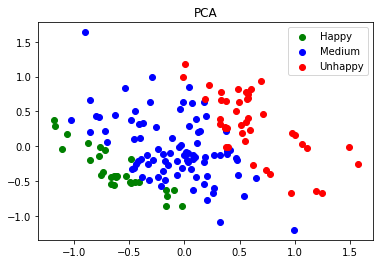

In [0]:
happy = data.loc[data['Happiness Score']>=6.5]
medium = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<6.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['pca-one'], happy['pca-two'], c='green', label='Happy')
plt.scatter(medium['pca-one'], medium['pca-two'], c='blue', label='Medium')
plt.scatter(unhappy['pca-one'], unhappy['pca-two'], c='red', label='Unhappy')
plt.legend()
plt.title('PCA');

In [0]:
#Clustering using k-means

from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=20, max_iter=600, 
    tol=1e-04, random_state=0
)
y_km = km.fit(data[sel_features].values)
y_pred = y_km.labels_.astype(np.int)

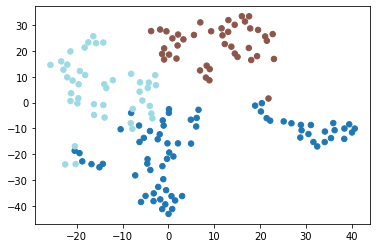

In [0]:
#confronto con tSNE
ax = plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=y_pred, cmap='tab20')

Proviamo a scegliere k andando ad analizzare se i dati indicano qualche preferenza specifica, questo può essere fatto sia guardando alla **distortion** (metodo dell'elbow): *somma delle distanze quadratiche dei campioni dai centri dei cluster più vicini*. 

Ci aspettiamo che la distortion subisca un cambio di pendenza una volta raggiunto il k ottimale ...

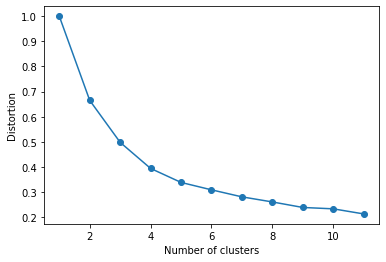

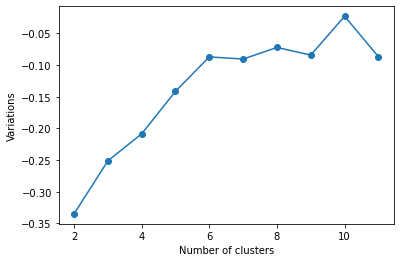

In [0]:
# calcoliamo il best k usando la distorsione
# NOTA: distorsione: Sum of squared distances of samples to their closest cluster center
k_max=12
distortions = []
variations = []
old = 0
for i in range(1, k_max):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=20, max_iter=600,
        tol=1e-04, random_state=0
    )
    km.fit(data[sel_features].values)
    
    distortions.append(km.inertia_)
    if (i>1):
       variations.append((km.inertia_-old)/old)
    old = km.inertia_

# plot
plt.plot(range(1, k_max), distortions/distortions[0], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
plt.plot(range(2, k_max), variations, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Variations')
plt.show()

indicazione di un k tra 4 e 6.

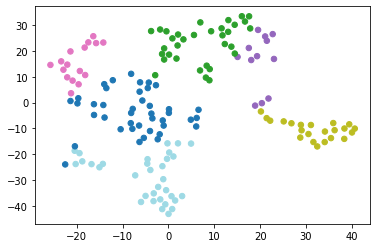

In [0]:
#Clustering using k-means

from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=6, init='k-means++',
    n_init=20, max_iter=600, 
    tol=1e-04, random_state=0
)
y_km = km.fit(data[sel_features].values)
y_pred = y_km.labels_.astype(np.int)

ax = plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=y_pred, cmap='tab20')


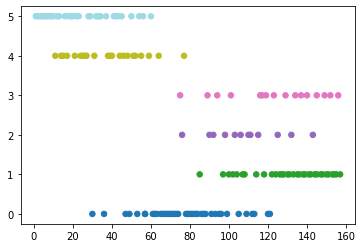

In [0]:
ax = plt.scatter(data['Happiness Rank'],y_pred, s=30, c=y_pred, cmap='tab20')

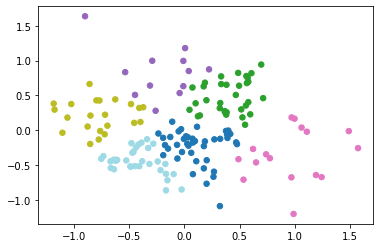

In [0]:
ax = plt.scatter(data['pca-one'],data['pca-two'], s=30, c=y_pred, cmap='tab20')

### Esercizi: ###

* testare i vari algoritmi di clustering in funzione dei loro parametri

* indentificare quali tra le feature del World Happines report dataset forniscono i maggior contributo all'Happines Rank: i.e. cosa rende un paese felice?

#**Test degli algoritmi di clustering**

Analizziamo il comportamento dei vari algoritmi di clustering riportati al variare del dataset. Poiché il dataset *blobs* è correttamente analizzato da tutti gli algoritmi, esso non verrà commentato nell'analisi, in quanto poco significativo al fine di individuare differenze nell'efficacia degli algoritmi.

Per quanto riguarda i dataset topologici, è preferibile utilizzare algortimi basati sulla densità di punti, ovvero Spectral Clustering, Agglomerative Clustering, DBSCAN e Optics. Partiamo dunque con il testare questi algoritmi.

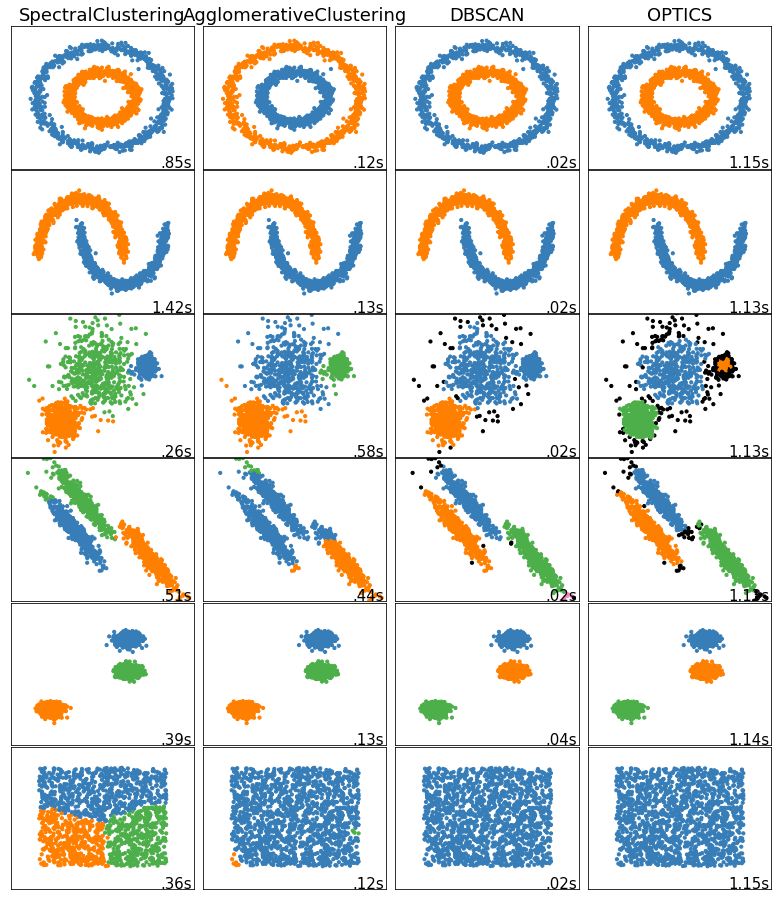

In [0]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(11, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]


# loop su i 6 datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

# Algoritmi di clustering per il confronto
    clustering_algorithms = (
        #('AffinityPropagation', affinity_propagation),
        ('SpectralClustering', spectral),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Osserviamo che DBSCAN è l'algoritmo più versatile ed efficiente per operare sui dataset proposti. Sebbene non riesca ad assegnare ad alcun cluster alcuni punti di *varied* (nel quale commette anche un errore nella valutazione di un cluster) ed *aniso*, individua correttamente i clusters di ciascun dataset in un tempo di run molto breve. <br />
Un discorso analogo vale per Optics, il quale tuttavia fallisce nell'analisi di più punti di *varied* e *aniso* e impiega un tempo di run molto più alto. <br />
Con Agglomerative Clustering torniamo a lavorare con un algoritmo veloce. In questo caso, però, la performance generale cala: i clusters di *varied* e *no structure*, infatti presentano diversi errori. <br />
Infine, Spectral Clustering commette ancora errori in *varied* e *no structure*, impiegando un tempo di run di poco maggiore di quello di Agglomerative Clustering.

Passiamo allo studio degli altri algoritmi disponibili (Mini-Batch K-means, Affinity Propagation, Mean Shift, Ward, Birch e Gaussian Mixture).

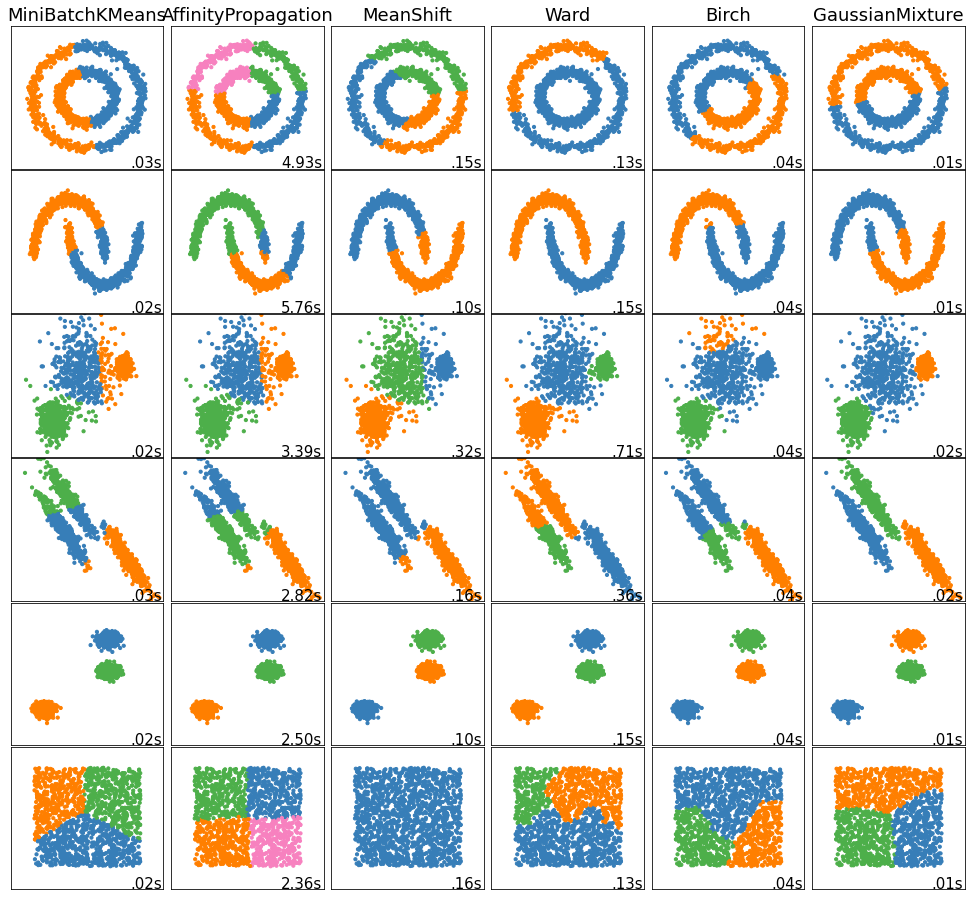

In [0]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 1.2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]


# loop su i 6 datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

# Algoritmi di clustering per il confronto
    clustering_algorithms = (
        # k-means (con mini-batch)
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        #('SpectralClustering', spectral),
        ('Ward', ward),
        #('AgglomerativeClustering', average_linkage),
        #('DBSCAN', dbscan),
        #('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Tutti gli algoritmi testati in questa fase falliscono nell'analisi di dataset topologici, quali *noisy_circles* e *noisy_moons*, per il quale solo Ward riesce ad individuare correttamente i clusters. <br />
Il migliore algoritmo risulta essere Gaussian Mixture, che in un tempo di run molto breve riesce ad individuare correttamente tre dei quattro clusters non topologici.
Ward e Mean Shift ottengono risultati corretti in due casi su quattro, impiegando tempi di run molto simili. In particolare, Mean Shift è l'unico a riconoscere correttamente un unico cluster in *no structure*. <br />
Birch e Mini-Batch K-means individuano i cluster giusti solo nel caso di *blob*, mentre dividono *no structure* in tre clusters. Presentano ancora dei tempi di run piuttosto rapidi. <br />
Il peggiore algoritmo per i dataset proposti è indiscutibilmente Affinity Propagation: l'unica sua analisi riuscita è infatti quella di *blobs* e, a differenza di Birch e Mini-Batch K-means, presenta un tempo di run molto più lungo.

#**Cosa rende un Paese felice?**

Tentiamo ora di capire quali tra i fattori disponibili nel World Happiness Record contribuiscano maggiormente nella definizione della classifica dei Paesi più "felici".

In [0]:
#leggiamo il dataset con pandas

import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/2016.csv')
sel_features = ['Economy (GDP per Capita)','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual']
data

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Benin,Sub-Saharan Africa,153,3.484,3.404,3.564,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812
153,Afghanistan,Southern Asia,154,3.360,3.288,3.432,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558
154,Togo,Sub-Saharan Africa,155,3.303,3.192,3.414,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540
155,Syria,Middle East and Northern Africa,156,3.069,2.936,3.202,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789


In [0]:
# summary statistic del dataset

data[sel_features].describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.953880,0.793621,0.557619,0.370994,0.137624,0.242635,2.325807
std,0.412595,0.266706,0.229349,0.145507,0.111038,0.133756,0.542220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817890
25%,0.670240,0.641840,0.382910,0.257480,0.061260,0.154570,2.031710
50%,1.027800,0.841420,0.596590,0.397470,0.105470,0.222450,2.290740
75%,1.279640,1.021520,0.729930,0.484530,0.175540,0.311850,2.664650
max,1.824270,1.183260,0.952770,0.608480,0.505210,0.819710,3.837720


In [0]:
# controllo sulla correlazione dei dati
data[sel_features].corr()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Economy (GDP per Capita),1.000000,0.669540,0.837067,0.362283,0.294185,-0.025531,0.068624
Family,0.669540,1.000000,0.588377,0.450208,0.213561,0.089629,0.119672
Health (Life Expectancy),0.837067,0.588377,1.000000,0.341199,0.249583,0.075987,0.100857
Freedom,0.362283,0.450208,0.341199,1.000000,0.502054,0.361751,0.091631
Trust (Government Corruption),0.294185,0.213561,0.249583,0.502054,1.000000,0.305930,-0.002909
Generosity,-0.025531,0.089629,0.075987,0.361751,0.305930,1.000000,-0.133001
Dystopia Residual,0.068624,0.119672,0.100857,0.091631,-0.002909,-0.133001,1.000000


Notiamo una elevata correlazione tra il PIL pro capite e l'aspettativa di vita. Una prima analisi potrebbe quindi portarci ad identificare questi due fattori come quelli maggiormente determinanti.

Testiamo questa ipotesi con i metodi del clustering. Operiamo dapprima una trasformazione dei dati tramite tSNE.

In [0]:
# visualizzazione con t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# sklearn tSNE con pre-pca applicata 
# typical value for perplexity between 5 and 50 (should be tested)
tsne = TSNE(n_components=2, init='pca', perplexity = 10)
tsne_data = tsne.fit_transform(data[sel_features])
data['tsne-one'] = tsne_data[:,0]
data['tsne-two'] = tsne_data[:,1]

Attraverso il metodo dell'elbow, tentiamo di prevedere quale sia il numero corretto di clusters da impostare per gli algoritmi che utilizzeremo.

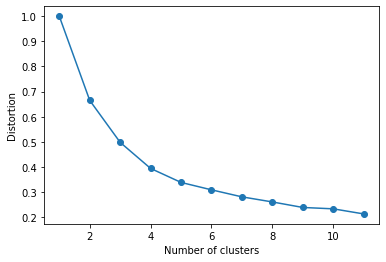

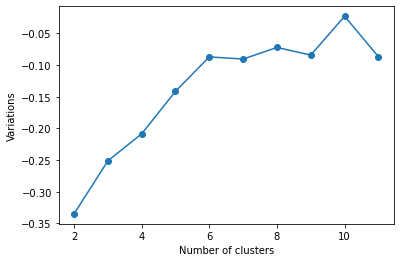

In [0]:
# calcoliamo il best k usando la distorsione
k_max=12
distortions = []
variations = []
old = 0
for i in range(1, k_max):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=20, max_iter=600,
        tol=1e-04, random_state=0
    )
    km.fit(data[sel_features].values)
    
    distortions.append(km.inertia_)
    if (i>1):
       variations.append((km.inertia_-old)/old)
    old = km.inertia_

# plot
plt.plot(range(1, k_max), distortions/distortions[0], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
plt.plot(range(2, k_max), variations, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Variations')
plt.show()

Otteniamo un numero di clusters ottimale compreso tra 4 e 6. Impostiamolo pari a 4: dividiamo cioè i Paesi del mondo in quattro gruppi in base alla loro felicità. Riportiamo di seguito la suddivisione reale usando quattro clusters.

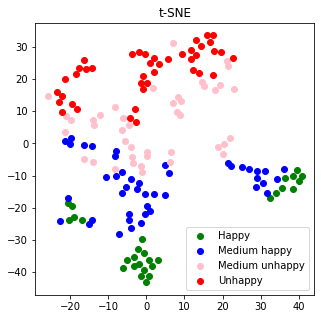

In [0]:
#plot dei risultati
plt.figure(figsize=(5,5))

happy = data.loc[data['Happiness Score']>=6.5]
medium_ha = data.loc[(data['Happiness Score']>5.5) & (data['Happiness Score']<6.5)]
medium_un = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<=5.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['tsne-one'], happy['tsne-two'], c='green', label='Happy')
plt.scatter(medium_ha['tsne-one'], medium_ha['tsne-two'], c='blue', label='Medium happy')
plt.scatter(medium_un['tsne-one'], medium_un['tsne-two'], c='pink', label='Medium unhappy')
plt.scatter(unhappy['tsne-one'], unhappy['tsne-two'], c='red', label='Unhappy')
plt.legend()
plt.title('t-SNE');

Intendiamo ora riproporre un clustering quanto più simile possibile a quello reale. A tal fine, usiamo diversi algoritmi: Mini-Batch K-means, Gaussian Mixture, DBSCAN e Spectral Clustering.

In [0]:
#Clustering using Mini-batch k-means
from sklearn.cluster import KMeans
n_clusters = 4
#After several tests we decide the best batch size for this problem is 20
minik = cluster.MiniBatchKMeans(n_clusters=n_clusters,
                                batch_size=20, random_state=0,
                                tol=1e-4, n_init=10)

minik_fit = minik.fit(data[sel_features].values)
minik_pred = minik_fit.labels_.astype(np.int)

In [0]:
#Clustering using Gaussian Mixture
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=n_clusters, 
                      max_iter=3000, 
                      init_params='kmeans')
gmm.fit(data[sel_features].values)
gmm_scores = gmm.score_samples(data[sel_features].values)
gmm_pred = gmm.predict(data[sel_features].values)

In [0]:
#Clustering using DBSCAN
db = cluster.DBSCAN(eps=params['eps'])
db.fit(data[sel_features].values)
db_scores = gmm.score_samples(data[sel_features].values)
db_pred = gmm.predict(data[sel_features].values)

In [0]:
#Spectral Clustering
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
spectral.fit(data[sel_features].values)
spectral_scores = gmm.score_samples(data[sel_features].values)
spectral_pred = gmm.predict(data[sel_features].values)

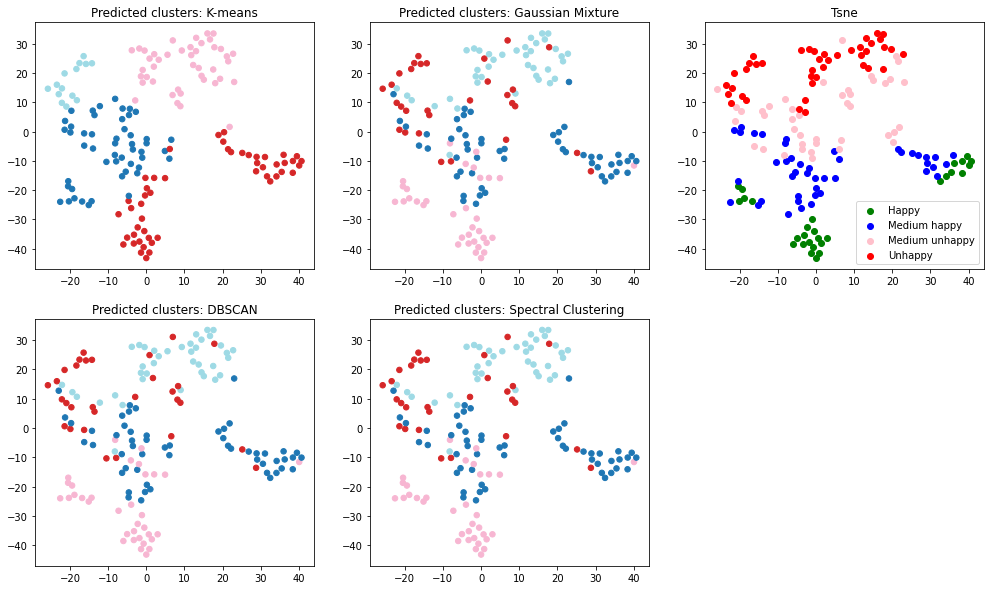

In [0]:
plt.close()
plt.figure(figsize=(17,10))
#Confronto grafico
ax1 = plt.subplot(2, 3, 1)
ax1= plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=minik_pred, cmap='tab20')
ax1 = plt.title('Predicted clusters: K-means')
ax2 = plt.subplot(2, 3, 2)
ax2=plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=gmm_pred, cmap='tab20')
ax2 = plt.title('Predicted clusters: Gaussian Mixture')
ax1 = plt.subplot(2, 3, 3)
ax1 = plt.scatter(happy['tsne-one'], happy['tsne-two'], c='green', label='Happy')
ax1 = plt.scatter(medium_ha['tsne-one'], medium_ha['tsne-two'], c='blue', label='Medium happy')
ax1 = plt.scatter(medium_un['tsne-one'], medium_un['tsne-two'], c='pink', label='Medium unhappy')
ax1 = plt.scatter(unhappy['tsne-one'], unhappy['tsne-two'], c='red', label='Unhappy')
ax1 = plt.legend()
ax1 = plt.title('Tsne')
ax2 = plt.subplot(2, 3, 4)
ax2= plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=db_pred, cmap='tab20')
ax2 = plt.title('Predicted clusters: DBSCAN')
ax1 = plt.subplot(2, 3, 5)
ax1=plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=spectral_pred, cmap='tab20')
ax1 = plt.title('Predicted clusters: Spectral Clustering')

Sebbene Mini-Batch K-means distingua più nettamente i clusters individuati, Gaussian Mixture, DBSCAN e Spectral Clustering suddividono i dati in modo più simile a quanto osservato con tSNE. Pertanto, nel seguito si prediligerà l'uso di Gaussian Mixture.

Riportiamo ora delle rappresentazioni grafiche dell'aspettativa di vita e del PIL pro capite. In primo luogo, mostriamo l'andamento delle features in funzione dell'Happiness Rank, utilizzando il colore come indicatore della predizione dell'algoritmo. Successivamente, poniamo come ascissa l'indice del Paese e come ordinata l'indice del cluster e indichiamo con il colore il valore della feature.

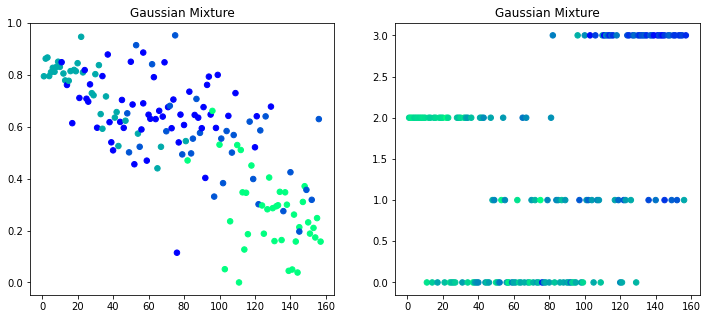

In [0]:
#Health (Life expectancy)
plt.close()
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1, 2, 1)
ax1=plt.scatter(data['Happiness Rank'],data['Health (Life Expectancy)'], s=30, c=gmm_pred, cmap='winter')
ax1 = plt.title('Gaussian Mixture')
ax2 = plt.subplot(1, 2, 2)
ax2=plt.scatter(data['Happiness Rank'],gmm_pred, s=30, c=data['Health (Life Expectancy)'], cmap='winter')
ax2 = plt.title('Gaussian Mixture')

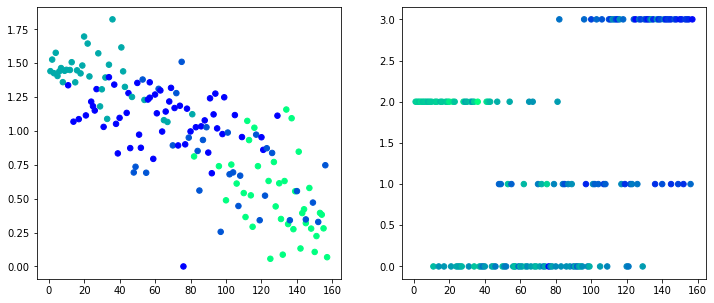

In [0]:
#Economy (GDP per capita)
plt.close()
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1, 2, 1)
ax1=plt.scatter(data['Happiness Rank'],data['Economy (GDP per Capita)'], s=30, c=gmm_pred, cmap='winter')

ax2 = plt.subplot(1, 2, 2)
ax2 = plt.scatter(data['Happiness Rank'],gmm_pred, s=30, c=data['Economy (GDP per Capita)'], cmap='winter')

Osserviamo che, per entrambe le features, i grafici a sinistra mostrano una suddivisione per colore (ovvero per predizione della "felicità") piuttosto netta. La stessa suddivisione è riscontrabile nei grafici di destra, dove ciascuna linea appare popolata da punti dello stesso colore.

Lo studio fin qui condotto ci porta ad affermare che l'aspettativa di vita ed il PIL pro capite siano i fattori dominanti nella determinazione dell'Happiness Score. Come ultimo test, addestriamo una random forest con il dataset del World Happiness Report e ricaviamo le *feature importances*, ovvero il peso di ciascuna feature nel determinare la label del Paese.

In [0]:
#reimportiamo il dataset e dividiamo i Paesi in due gruppi (felici e infelici)
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/2016.csv')
happy = data['Happiness Score'] >=6.5
M = np.ones(157)
for i in range(157):
  if happy[i] == False:
    M[i] = 0

Y = M

In [0]:
#Eliminiamo le colonne non corrispondenti a parametri reali
intermediate = data.drop(columns=['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Dystopia Residual'])
X = intermediate.to_numpy()

In [0]:
#Addestriamo la foresta e ricaviamo le feature importances
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X,Y)

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('Feature by percentage of importance:\n')
for f in range(X.shape[1]):
  print('%d feature %d  (%f)' %(f+1, indices[f], importances[indices[f]]))

Feature by percentage of importance:

1 feature 2  (0.287838)
2 feature 0  (0.226581)
3 feature 4  (0.147804)
4 feature 1  (0.135800)
5 feature 3  (0.132254)
6 feature 5  (0.069723)


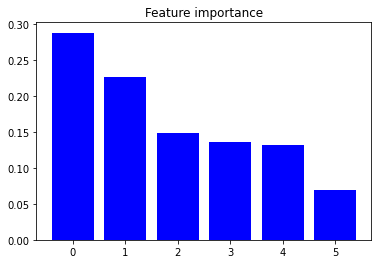

In [0]:
#Grafichiamo l'istogramma delle featue importances, ponendo come indice sull'asse
#delle ascisse la posizione nella classifica delle feature più preponderanti
plt.figure()
plt.title('Feature importance')
plt.bar(range(X.shape[1]), importances[indices], color='b')
plt.show()

Anche questo tipo di analisi ci conduce al risultato già ottenuto in precedenza: l'aspettativa di vita assume un peso del $28.8\%$ nell'addestramento della foresta, mentre il PIL pro capite si attesta sul $22.7\%$. Le altre features sono più distanziate. Pertanto, possiamo concludere che l'aspettativa di vita ed il PIL pro capite diano il contributo maggiore nella stesura della classifica dei Paesi più "felici".